# WPA Model for NHL Games

This Notebook creates a Win-Probability Model for NHL Games using XGBoost and this [Kaggle](<https://www.kaggle.com/datasets/s903124/nhl-playbyplay-data-from-2007?resource=download>) for training and testing data.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importing Data and Packages

In [49]:
! pip install plotly==4.4.0
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.graph_objects as go

In [32]:
pbp_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_pbp20192020.csv"
shifts_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_shifts20192020.csv"
roster_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/roster20192020.csv"

In [33]:
pbp = pd.read_csv(pbp_path)
shifts = pd.read_csv(shifts_path)
roster = pd.read_csv(roster_path)
pbp.head()

,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,Type,...,Away_Score,Home_Score,Away_Goalie,Away_Goalie_Id,Home_Goalie,Home_Goalie_Id,xC,yC,Home_Coach,Away_Coach
0,20001,2019-10-02,1,PSTR,Period Start- Local time: 7:13 EDT,0:00,0.0,5x5,NaN,NaN,...,0,0,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,NaN,NaN,MIKE BABCOCK,D.J. SMITH
1,20001,2019-10-02,1,FAC,TOR won Neu. Zone - OTT #36 WHITE vs TOR #91 T...,0:00,0.0,5x5,Neu,NaN,...,0,0,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,0.0,0.0,MIKE BABCOCK,D.J. SMITH
2,20001,2019-10-02,1,GOAL,"OTT #7 TKACHUK(1), Tip-In, Off. Zone, 4 ft.Ass...",0:25,25.0,5x5,Off,TIP-IN,...,0,0,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,85.0,-1.0,MIKE BABCOCK,D.J. SMITH
3,20001,2019-10-02,1,FAC,OTT won Neu. Zone - OTT #71 TIERNEY vs TOR #88...,0:25,25.0,5x5,Neu,NaN,...,1,0,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,0.0,0.0,MIKE BABCOCK,D.J. SMITH
4,20001,2019-10-02,1,MISS,"OTT #22 ZAITSEV, Slap, Wide of Net, Neu. Zone,...",0:38,38.0,5x5,Neu,SLAP SHOT,...,1,0,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,28.0,-37.0,MIKE BABCOCK,D.J. SMITH


In [34]:
print("pbp:", pbp.columns.tolist())
print("shifts:", shifts.columns.tolist())
print("roster:", roster.columns.tolist())

pbp: ['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed', 'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team', 'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name', 'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id', 'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id', 'awayPlayer4', 'awayPlayer4_id', 'awayPlayer5', 'awayPlayer5_id', 'awayPlayer6', 'awayPlayer6_id', 'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id', 'homePlayer3', 'homePlayer3_id', 'homePlayer4', 'homePlayer4_id', 'homePlayer5', 'homePlayer5_id', 'homePlayer6', 'homePlayer6_id', 'Away_Players', 'Home_Players', 'Away_Score', 'Home_Score', 'Away_Goalie', 'Away_Goalie_Id', 'Home_Goalie', 'Home_Goalie_Id', 'xC', 'yC', 'Home_Coach', 'Away_Coach']
shifts: ['Game_Id', 'Period', 'Team', 'Player', 'Player_Id', 'Start', 'End', 'Duration', 'Date']
roster: ['#', 'Pos', 'Name', 'Scratches', 'game_id']


In [35]:
print(pbp.dtypes)

Game_Id              int64
Date                object
Period               int64
Event               object
Description         object
Time_Elapsed        object
Seconds_Elapsed    float64
Strength            object
Ev_Zone             object
Type                object
Ev_Team             object
Home_Zone           object
Away_Team           object
Home_Team           object
p1_name             object
p1_ID              float64
p2_name             object
p2_ID              float64
p3_name             object
p3_ID              float64
awayPlayer1         object
awayPlayer1_id     float64
awayPlayer2         object
awayPlayer2_id     float64
awayPlayer3         object
awayPlayer3_id     float64
awayPlayer4         object
awayPlayer4_id     float64
awayPlayer5         object
awayPlayer5_id     float64
awayPlayer6         object
awayPlayer6_id     float64
homePlayer1         object
homePlayer1_id     float64
homePlayer2         object
homePlayer2_id     float64
homePlayer3         object
h

In [36]:
print(shifts.dtypes)

Game_Id        int64
Period         int64
Team          object
Player        object
Player_Id      int64
Start        float64
End          float64
Duration     float64
Date          object
dtype: object


In [37]:
print(roster.dtypes)

#             int64
Pos          object
Name         object
Scratches      bool
game_id       int64
dtype: object


## 2. Preparing Data for WP Model

In [38]:
pbp.groupby(['Game_Id', 'Ev_Team'])['Game_Id'].count()

Game_Id  Ev_Team
20001    OTT        154
         TOR        156
20002    STL        113
         WSH        128
20003    EDM        125
                   ... 
30321    VGK        144
30322    DAL        137
         VGK        161
30323    DAL        153
         VGK        162
Name: Game_Id, Length: 2402, dtype: int64

In [39]:
pbp['home_max_goal'] = pbp['Home_Score'].groupby(pbp['Game_Id']).transform('max')
pbp['away_max_goal'] = pbp['Away_Score'].groupby(pbp['Game_Id']).transform('max')
pbp.head()

,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,Type,...,Away_Goalie,Away_Goalie_Id,Home_Goalie,Home_Goalie_Id,xC,yC,Home_Coach,Away_Coach,home_max_goal,away_max_goal
0,20001,2019-10-02,1,PSTR,Period Start- Local time: 7:13 EDT,0:00,0.0,5x5,NaN,NaN,...,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,NaN,NaN,MIKE BABCOCK,D.J. SMITH,5,3
1,20001,2019-10-02,1,FAC,TOR won Neu. Zone - OTT #36 WHITE vs TOR #91 T...,0:00,0.0,5x5,Neu,NaN,...,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,0.0,0.0,MIKE BABCOCK,D.J. SMITH,5,3
2,20001,2019-10-02,1,GOAL,"OTT #7 TKACHUK(1), Tip-In, Off. Zone, 4 ft.Ass...",0:25,25.0,5x5,Off,TIP-IN,...,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,85.0,-1.0,MIKE BABCOCK,D.J. SMITH,5,3
3,20001,2019-10-02,1,FAC,OTT won Neu. Zone - OTT #71 TIERNEY vs TOR #88...,0:25,25.0,5x5,Neu,NaN,...,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,0.0,0.0,MIKE BABCOCK,D.J. SMITH,5,3
4,20001,2019-10-02,1,MISS,"OTT #22 ZAITSEV, Slap, Wide of Net, Neu. Zone,...",0:38,38.0,5x5,Neu,SLAP SHOT,...,CRAIG ANDERSON,8467950.0,FREDERIK ANDERSEN,8475883.0,28.0,-37.0,MIKE BABCOCK,D.J. SMITH,5,3


Now we can create the second DataFrame to use in the WP Model

In [40]:
pbp['home_max_goal'] = pbp.groupby('Game_Id')['Home_Score'].transform('max')
pbp['away_max_goal'] = pbp.groupby('Game_Id')['Away_Score'].transform('max')

pbp['win'] = np.where(pbp['home_max_goal'] > pbp['away_max_goal'], 1, 0)

pbp['total_seconds_elapsed'] = ((pbp['Period'] - 1) * 1200) + pbp["Seconds_Elapsed"]
pbp['time_remaining'] = 3600 - pbp['total_seconds_elapsed']

pbp['score_diff'] = pbp['Home_Score'] - pbp['Away_Score']

pbp['skater_diff'] = pbp['Home_Players'] - pbp['Away_Players']
pbp['goalie_pulled'] = np.where(pbp['Home_Players'] < 5, 1, 0)
pbp['power_play'] = np.where((pbp['Home_Players'] > pbp['Away_Players']) | (pbp['Away_Players'] > pbp['Home_Players']), 1, 0)

shifts_agg = shifts.groupby(['Game_Id', 'Player_Id'])['Duration'].sum().reset_index()
pbp = pbp.merge(shifts_agg, left_on=['Game_Id', 'p1_ID'], right_on=['Game_Id', 'Player_Id'], how='left')
pbp.rename(columns={'Duration': 'ice_time'}, inplace=True)
pbp['ice_time'] = pbp['ice_time'].fillna(0)

wp_df = pbp[['Game_Id', 'p1_name', 'Ev_Team', 'time_remaining', 'score_diff', 'skater_diff', 'goalie_pulled', 'ice_time', 'win']]

wp_df = wp_df.dropna()
wp_df.head()



,Game_Id,p1_name,Ev_Team,time_remaining,score_diff,skater_diff,goalie_pulled,ice_time,win
1,20001,JOHN TAVARES,TOR,3600.0,0,0,0,1093.0,1
2,20001,BRADY TKACHUK,OTT,3575.0,0,0,0,1052.0,1
3,20001,CHRIS TIERNEY,OTT,3575.0,-1,0,0,1061.0,1
4,20001,NIKITA ZAITSEV,OTT,3562.0,-1,0,0,1439.0,1
6,20001,ARTEM ANISIMOV,OTT,3562.0,-1,0,0,1180.0,1


In [22]:
print(wp_df.dtypes)

Game_Id             int64
p1_name            object
Ev_Team            object
time_remaining    float64
score_diff          int64
skater_diff         int64
goalie_pulled       int64
ice_time          float64
ice_time          float64
win                 int64
dtype: object


In [17]:
wp_df.tail()

,Game_Id,p1_name,Ev_Team,time_remaining,score_diff,skater_diff,goalie_pulled,ice_time,win
378317,30313,MATT MARTIN,NYI,2428.0,2,-1,0,749.0,1
378318,30313,BARCLAY GOODROW,T.B,2428.0,2,-2,0,1082.0,1
378319,30313,CEDRIC PAQUETTE,T.B,2428.0,2,0,0,772.0,1
378320,30313,PAT MAROON,T.B,2406.0,2,0,0,728.0,1
378321,30313,LUKE SCHENN,T.B,2402.0,2,0,0,471.0,1


In [41]:
train_games, test_games = train_test_split(wp_df['Game_Id'].unique(), test_size=0.3, random_state=2142)
train_df = wp_df[wp_df['Game_Id'].isin(train_games)]
test_df = wp_df[wp_df['Game_Id'].isin(test_games)]


X_train = train_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1)
Y_train = train_df[['win']]

X_test = test_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1)
Y_test = test_df[['win']]


sm = SMOTE(random_state=2142)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

In [42]:
model = LogisticRegression()
model.fit(X_train_res, Y_train_res.values.ravel())

Y_pred = model.predict(X_test)
Y_pred_proba = model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

Accuracy: 0.6950
Precision: 0.8008
Recall: 0.5542
ROC-AUC: 0.7998


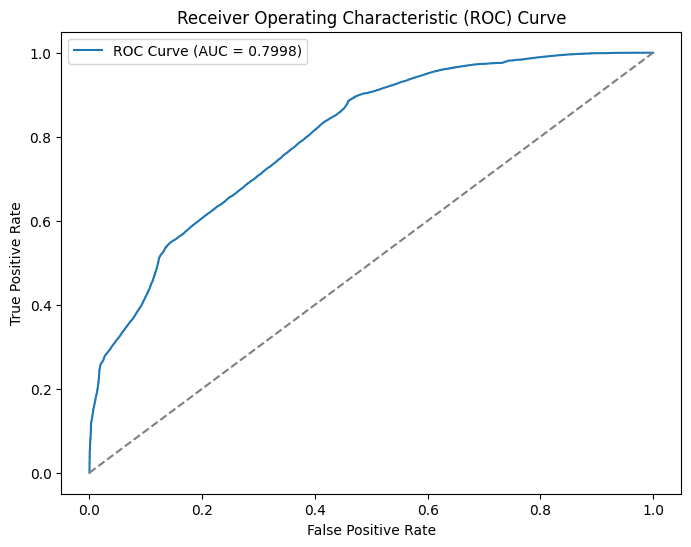

In [44]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

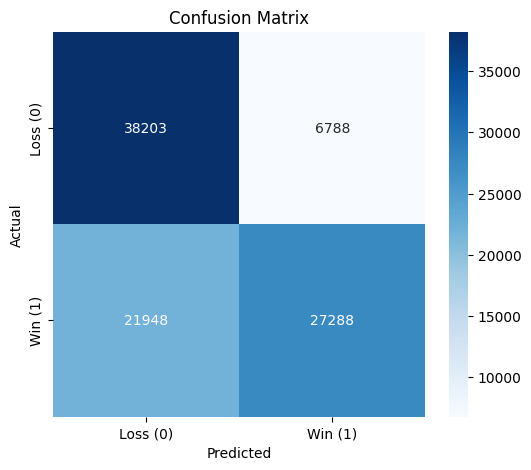

In [45]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss (0)", "Win (1)"], yticklabels=["Loss (0)", "Win (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
wp_df["win_probability"] = model.predict_proba(wp_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1))[:, 1]
wp_df.head()

,Game_Id,p1_name,Ev_Team,time_remaining,score_diff,skater_diff,goalie_pulled,ice_time,win,win_probability
1,20001,JOHN TAVARES,TOR,3600.0,0,0,0,1093.0,1,0.486947
2,20001,BRADY TKACHUK,OTT,3575.0,0,0,0,1052.0,1,0.487134
3,20001,CHRIS TIERNEY,OTT,3575.0,-1,0,0,1061.0,1,0.240282
4,20001,NIKITA ZAITSEV,OTT,3562.0,-1,0,0,1439.0,1,0.238387
6,20001,ARTEM ANISIMOV,OTT,3562.0,-1,0,0,1180.0,1,0.239661


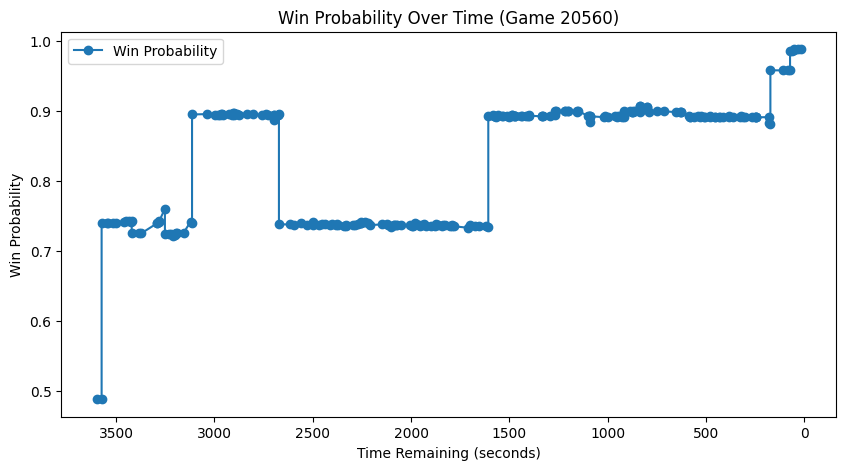

In [47]:
import matplotlib.pyplot as plt


game_id = 20560
game_events = wp_df[wp_df["Game_Id"] == game_id]

plt.figure(figsize=(10,5))
plt.plot(game_events["time_remaining"], game_events["win_probability"], label="Win Probability", marker="o")
plt.xlabel("Time Remaining (seconds)")
plt.ylabel("Win Probability")
plt.title(f"Win Probability Over Time (Game {game_id})")
plt.legend()
plt.gca().invert_xaxis()
plt.show()


In [50]:
def moving_average(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

game_id = 20560
game_events = wp_df[wp_df["Game_Id"] == game_id].sort_values(by="time_remaining")

game_events["win_probability_smooth"] = moving_average(game_events["win_probability"], window_size=5)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=game_events["time_remaining"],
    y=game_events["win_probability_smooth"],
    mode="lines",
    name="Smoothed Win Probability",
    line=dict(color="blue", width=2)
))


fig.update_layout(
    title=f"Smoothed Win Probability Over Time (Game {game_id})",
    xaxis_title="Time Remaining (seconds)",
    yaxis_title="Win Probability",
    xaxis=dict(autorange="reversed"),  # Ensure time runs from max to 0
    template="plotly_white"
)

fig.show()
